In [1]:
import os, json, sys, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set up

## Datasets

### Phenopackets results

In [2]:
# load Phenopacket results data
pp_results = os.path.expanduser('~/scratch-llm/results/disease_mode/evaluation/phenopackets_diseases_results.csv')
with open(pp_results, 'r') as f:
    pp_results = pd.read_csv(f)

### Orphanet results, all and very frequent

In [3]:
# load Orphanet results data
orpha_results = os.path.expanduser('~/scratch-llm/results/disease_mode/evaluation/orphanet_all_results.csv')
with open(orpha_results, 'r') as f:
    orpha_all_results = pd.read_csv(f)

In [4]:
orpha_results = os.path.expanduser('~/scratch-llm/results/disease_mode/evaluation/orphanet_frequent_results.csv')
with open(orpha_results, 'r') as f:
    orpha_freq_results = pd.read_csv(f)

# Data analysis

## Orphanet all symptoms

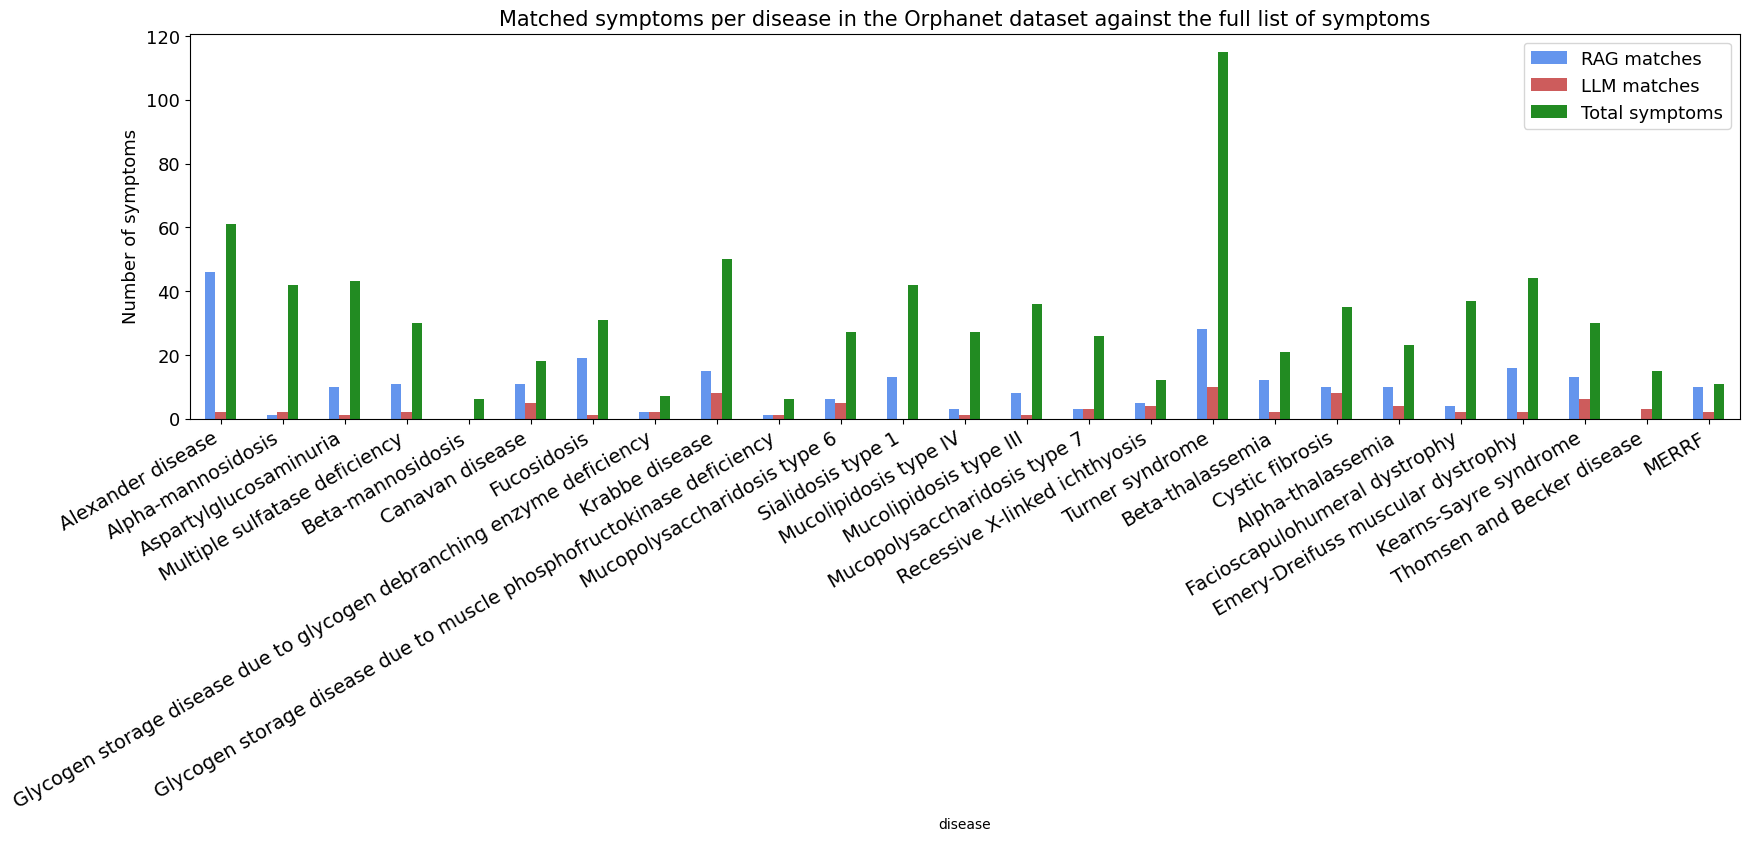

In [35]:
orpha_all_results[:25].plot(
    x="disease",
    y=["rag_matches", "no_rag_matches", "total_symptoms"],
    kind="bar",
    color=["cornflowerblue", "indianred", "forestgreen"],
    fontsize=13,
    figsize=(20, 5),
)
plt.title("Matched symptoms per disease in the Orphanet dataset against the full list of symptoms", fontsize=15)
plt.ylabel("Number of symptoms", fontsize=13)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.legend(["RAG matches", "LLM matches", "Total symptoms"], fontsize=13)
plt.show()

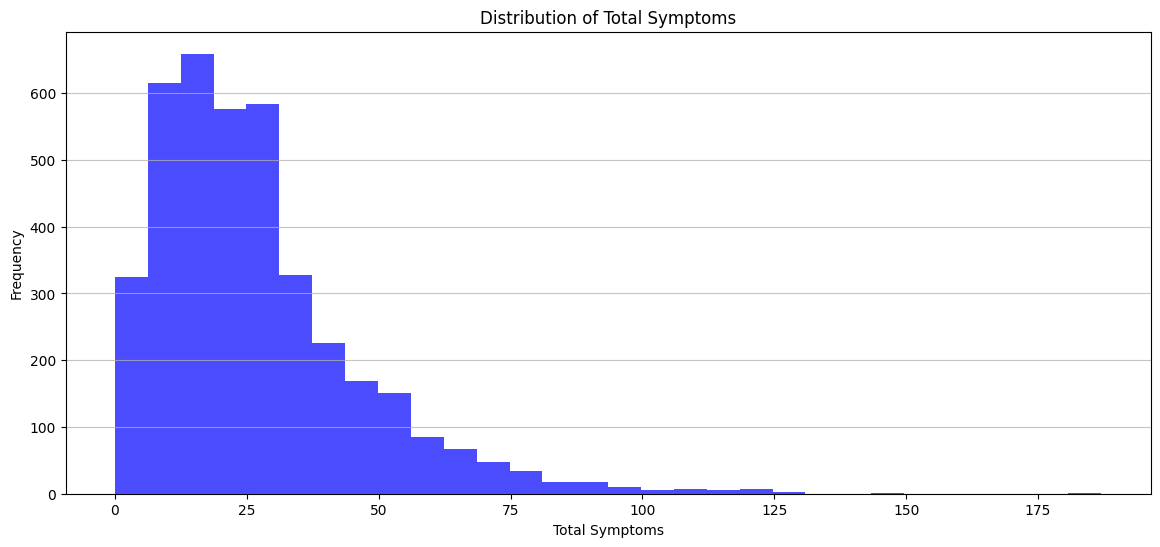

Mean number of symptoms: 27.0 
Max symptoms: 187 
Min symptoms: 0

Number of diseases with 0 symptoms: 1
Average number of symptoms in the RAG response: 24.0
Average number of symptoms in the LLM response: 25.0


In [6]:
plt.figure(figsize=(14, 6))
plt.hist(orpha_all_results['total_symptoms'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Total Symptoms')
plt.xlabel('Total Symptoms')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

#mean number of symptoms
mean_symptoms = orpha_all_results['total_symptoms'].mean()
print(f"Mean number of symptoms: {round(mean_symptoms,0)} \nMax symptoms: {orpha_all_results['total_symptoms'].max()} \nMin symptoms: {orpha_all_results['total_symptoms'].min()}")
print(f"\nNumber of diseases with 0 symptoms: {orpha_all_results[orpha_all_results['total_symptoms'] == 0].shape[0]}")

print(f"Average number of symptoms in the RAG response: {round(orpha_all_results['rag_total_symptoms'].mean(), 0)}")
print(f"Average number of symptoms in the LLM response: {round(orpha_all_results['no_rag_total_symptoms'].mean(), 0)}")

In [7]:
# calculate the percentage of RAG vs No-RAG matches across all diseases
rag_matches_percentage_all = orpha_all_results['rag_matches'].sum() / orpha_all_results['total_symptoms'].sum() * 100 
no_rag_matches_percentage_all = orpha_all_results['no_rag_matches'].sum() / orpha_all_results['total_symptoms'].sum() * 100
print(f"RAG matches: {round(rag_matches_percentage_all, 2)}% ({round(orpha_all_results['rag_matches'].mean(),0)} symptoms) \nLLM matches: {round(no_rag_matches_percentage_all, 2)}% ({round(orpha_all_results['no_rag_matches'].mean(),0)} symptoms)")


RAG matches: 42.08% (11.0 symptoms) 
LLM matches: 11.15% (3.0 symptoms)


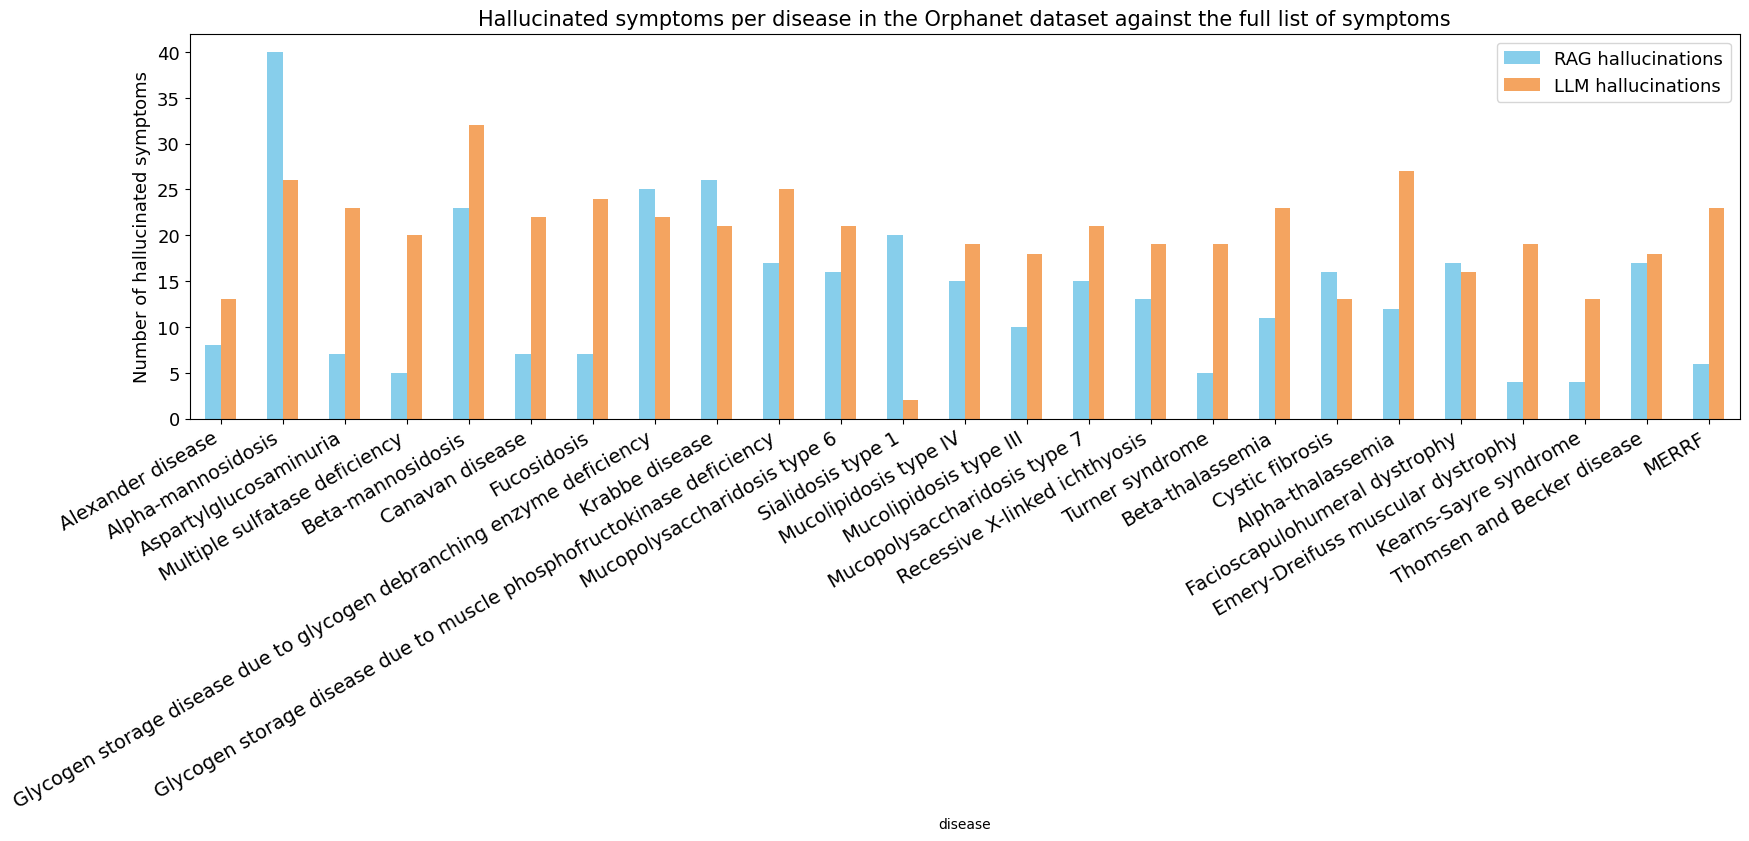

In [ ]:
orpha_all_results[:25].plot(
    x="disease",
    y=["rag_hallucinations", "no_rag_hallucinations"],#, "total_symptoms"],
    kind="bar",
    color=["skyblue", "sandybrown", "forestgreen"],
    figsize=(20, 5),
    fontsize=13,

)
plt.title("Hallucinated symptoms per disease in the Orphanet dataset against the full list of symptoms", fontsize=15)
plt.ylabel("Number of hallucinated symptoms", fontsize=13)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.legend(["RAG hallucinations", "LLM hallucinations"], loc="best", fontsize=13)
plt.show()

In [9]:
# average hallucinated symptoms generated
print(f"RAG hallucinations: {round(orpha_all_results['rag_hallucinations'].mean(), 0)} symptoms\nLLM hallucinations: {round(orpha_all_results['no_rag_hallucinations'].mean(), 0)} symptoms")

RAG hallucinations: 13.0 symptoms
LLM hallucinations: 22.0 symptoms


### Split by number of symptoms

In [10]:
symptom_counts = orpha_all_results['total_symptoms'].values

average_symptoms_per_disease = np.mean(symptom_counts) if len(symptom_counts) > 0 else 0
median_symptoms_per_disease = np.median(symptom_counts) if len(symptom_counts) > 0 else 0
std_dev_symptoms_per_disease = np.std(symptom_counts) if len(symptom_counts) > 0 else 0

print(f"Average number of symptoms per disease: {round(average_symptoms_per_disease, 0)}")
print(f"Median number of symptoms per disease: {round(median_symptoms_per_disease, 0)}")
print(f"Standard deviation of symptoms per disease: {round(std_dev_symptoms_per_disease, 0)}\n")

def assign_symptom_group(symptom_count):
    if symptom_count <= median_symptoms_per_disease:
        return "Low"
    elif symptom_count <= median_symptoms_per_disease + std_dev_symptoms_per_disease:
        return "Medium"
    else:
        return "High"

orpha_all_results['symptom_group'] = orpha_all_results['total_symptoms'].apply(assign_symptom_group)

for group in ['Low', 'Medium', 'High']:
    df = orpha_all_results[orpha_all_results['symptom_group'] == group]
    print(f"{group} group: {len(df)} diseases", end=" ")
    if len(df) > 0:
        rag_pct = df['rag_matches'].sum() / df['total_symptoms'].sum() * 100
        llm_pct = df['no_rag_matches'].sum() / df['total_symptoms'].sum() * 100
        print(f"| avg symptoms: {df['total_symptoms'].mean():.0f}")
        print(f"RAG matches: {rag_pct:.2f}% ({df['rag_matches'].mean():.0f} symptoms)")
        print(f"LLM matches: {llm_pct:.2f}% ({df['no_rag_matches'].mean():.0f} symptoms)\n")

# summary df
summary_df = pd.DataFrame({
    'Orphanet (all symptoms)': ['Low (<22 symptoms)', 'Medium (22-41 symptoms)', 'High (>41 symptoms)'],
    'Number of diseases': [len(orpha_all_results[orpha_all_results['symptom_group'] == group]) for group in ['Low', 'Medium', 'High']],
    'Average symptoms': [round(orpha_all_results[orpha_all_results['symptom_group'] == group]['total_symptoms'].mean(), 0) if len(orpha_all_results[orpha_all_results['symptom_group'] == group]) > 0 else 0 for group in ['Low', 'Medium', 'High']],
    'RAG matches (%)': [f"{(orpha_all_results[orpha_all_results['symptom_group'] == group]['rag_matches'].sum() / orpha_all_results[orpha_all_results['symptom_group'] == group]['total_symptoms'].sum() * 100):.2f}%" if orpha_all_results[orpha_all_results['symptom_group'] == group]['total_symptoms'].sum() > 0 else "0%" for group in ['Low', 'Medium', 'High']],
    'RAG hallucinations': [round(orpha_all_results[orpha_all_results['symptom_group'] == group]['rag_hallucinations'].mean(), 0) if len(orpha_all_results[orpha_all_results['symptom_group'] == group]) > 0 else 0 for group in ['Low', 'Medium', 'High']],
    'LLM matches (%)': [f"{(orpha_all_results[orpha_all_results['symptom_group'] == group]['no_rag_matches'].sum() / orpha_all_results[orpha_all_results['symptom_group'] == group]['total_symptoms'].sum() * 100):.2f}%" if orpha_all_results[orpha_all_results['symptom_group'] == group]['total_symptoms'].sum() > 0 else "0%" for group in ['Low', 'Medium', 'High']],
    'LLM hallucinations': [round(orpha_all_results[orpha_all_results['symptom_group'] == group]['no_rag_hallucinations'].mean(), 0) if len(orpha_all_results[orpha_all_results['symptom_group'] == group]) > 0 else 0 for group in ['Low', 'Medium', 'High']]
})
summary_df

Average number of symptoms per disease: 27.0
Median number of symptoms per disease: 22.0
Standard deviation of symptoms per disease: 19.0

Low group: 1997 diseases | avg symptoms: 13
RAG matches: 58.71% (8 symptoms)
LLM matches: 16.86% (2 symptoms)

Medium group: 1243 diseases | avg symptoms: 30
RAG matches: 42.92% (13 symptoms)
LLM matches: 11.01% (3 symptoms)

High group: 701 diseases | avg symptoms: 60
RAG matches: 31.13% (19 symptoms)
LLM matches: 7.78% (5 symptoms)



,Orphanet (all symptoms),Number of diseases,Average symptoms,RAG matches (%),RAG hallucinations,LLM matches (%),LLM hallucinations
0,Low (<22 symptoms),1997,13.0,58.71%,14.0,16.86%,23.0
1,Medium (22-41 symptoms),1243,30.0,42.92%,12.0,11.01%,22.0
2,High (>41 symptoms),701,60.0,31.13%,14.0,7.78%,22.0


### RAG context influence evaluation

RAG might receive 3 different types of context: <br>
&nbsp;&nbsp; a. Associated text from nodes <br>
&nbsp;&nbsp; b. List of HPO symptoms from the top_node <br>
&nbsp;&nbsp; c. Both together

In [11]:
#load all_nodes
all_nodes_file = os.path.expanduser('~/scratch-llm/storage/nodes/all_nodes.pkl')
with open(all_nodes_file, 'rb') as f:
    all_nodes = pickle.load(f)


In [12]:
# Create three lists to store the subsets
text_only = []
relations_only = []
text_and_relations = []
neither = []

# Iterate through orpha_all_results
for index, row in tqdm(orpha_all_results.iterrows(), desc="Processing Orphanet results"):
    top_node_id = row['rag_top_node_id']

    # Skip if no top_node_id or if it's NaN
    if pd.isna(top_node_id) or top_node_id is None:
        continue

    for i, node in enumerate(all_nodes):
        # find node_index
        if hasattr(node, 'metadata') and 'node_index' in node.metadata:
            if node.metadata['node_index'] == str(top_node_id):
                all_node_index = i
            
    # Find the 'top_node_id' in all_nodes
    node = all_nodes[all_node_index]
    # print(f"\nThe disease from Orphanet: {row['disease']} retrieved the following node from the graph")
    # print(f"Disease name: {node.metadata['node_name']} | ID: {node.metadata['node_index']} | index: {all_node_index}")
    # print(f"{node.text if hasattr(node, 'text') else 'No text'}")
    has_relations = False
    if hasattr(node, 'relationships'):
        for rel_type, rel_nodes in node.relationships.items():
            for rel in rel_nodes:
                if rel.metadata.get('relation') == 'disease_phenotype_positive':
                    # print(f"Phenotypes")
                    has_relations = True
                    break
            if has_relations:
                break

    # Check if node.text is not empty
    has_text = False
    if hasattr(node, 'text') and node.text is not None and not node.text.strip() != '':
        has_text = False
        # if text is false, check for text in nodes connected to it through disease-disease edges
        for rel_type, rel_nodes in node.relationships.items():
            for rel in rel_nodes:
                if rel.metadata.get('relation') == 'disease_disease':
                    # print(f"connected to: {rel.node_id}")
                    for i, node in enumerate(all_nodes):
                        if hasattr(node, 'metadata') and 'node_index' in node.metadata:
                            if node.metadata['node_index'] == str(rel.node_id):
                                # print(f"Found connected node: {node.metadata['node_name']} | ID: {node.metadata['node_index']} | text: {node.text}")
                                has_text = True # if one of the associated nodes has text break
                                break
                    
            if has_text:
                break
    else:
        has_text = True

    # Categorize based on what the node has
    disease_name = row #remove diseases

    if has_text and has_relations:
        text_and_relations.append(disease_name)
    elif has_text and not has_relations:
        text_only.append(disease_name)
    elif not has_text and has_relations:
        relations_only.append(disease_name)
    else:
        neither.append(disease_name)


text_only = pd.DataFrame(text_only)
relations_only = pd.DataFrame(relations_only)
text_and_relations = pd.DataFrame(text_and_relations)

print(f"\n\nDiseases with text only: {len(text_only)}")
print(f"Diseases with relations only: {len(relations_only)}")
print(f"Diseases with both text and relations: {len(text_and_relations)}")
print(f"Diseases with neither text nor relations: {len(neither)}")

avg_text_only = round(text_only['rag_matches'].sum() / text_only['total_symptoms'].sum() * 100, 2)
avg_relations_only = round(relations_only['rag_matches'].sum() / relations_only['total_symptoms'].sum() * 100, 2)
avg_text_and_relations = round(text_and_relations['rag_matches'].sum() / text_and_relations['total_symptoms'].sum() * 100, 2)


Processing Orphanet results: 3941it [08:34,  7.65it/s]




Diseases with text only: 532
Diseases with relations only: 2
Diseases with both text and relations: 3407
Diseases with neither text nor relations: 0


In [13]:
# input retrieves a node, how is that node:
disease_counts = pd.DataFrame({
    'Category': ['Text only', 'Phenotypes only', 'Text and phenotypes'],
    'Number of diseases': [len(text_only), len(relations_only), len(text_and_relations)],
    'Percentage matches': [f"{avg_text_only} %", f"{avg_relations_only} %", f"{avg_text_and_relations} %"]
})
disease_counts

,Category,Number of diseases,Percentage matches
0,Text only,532,11.97 %
1,Phenotypes only,2,31.46 %
2,Text and phenotypes,3407,46.67 %


## Orphanet very frequent/obligate

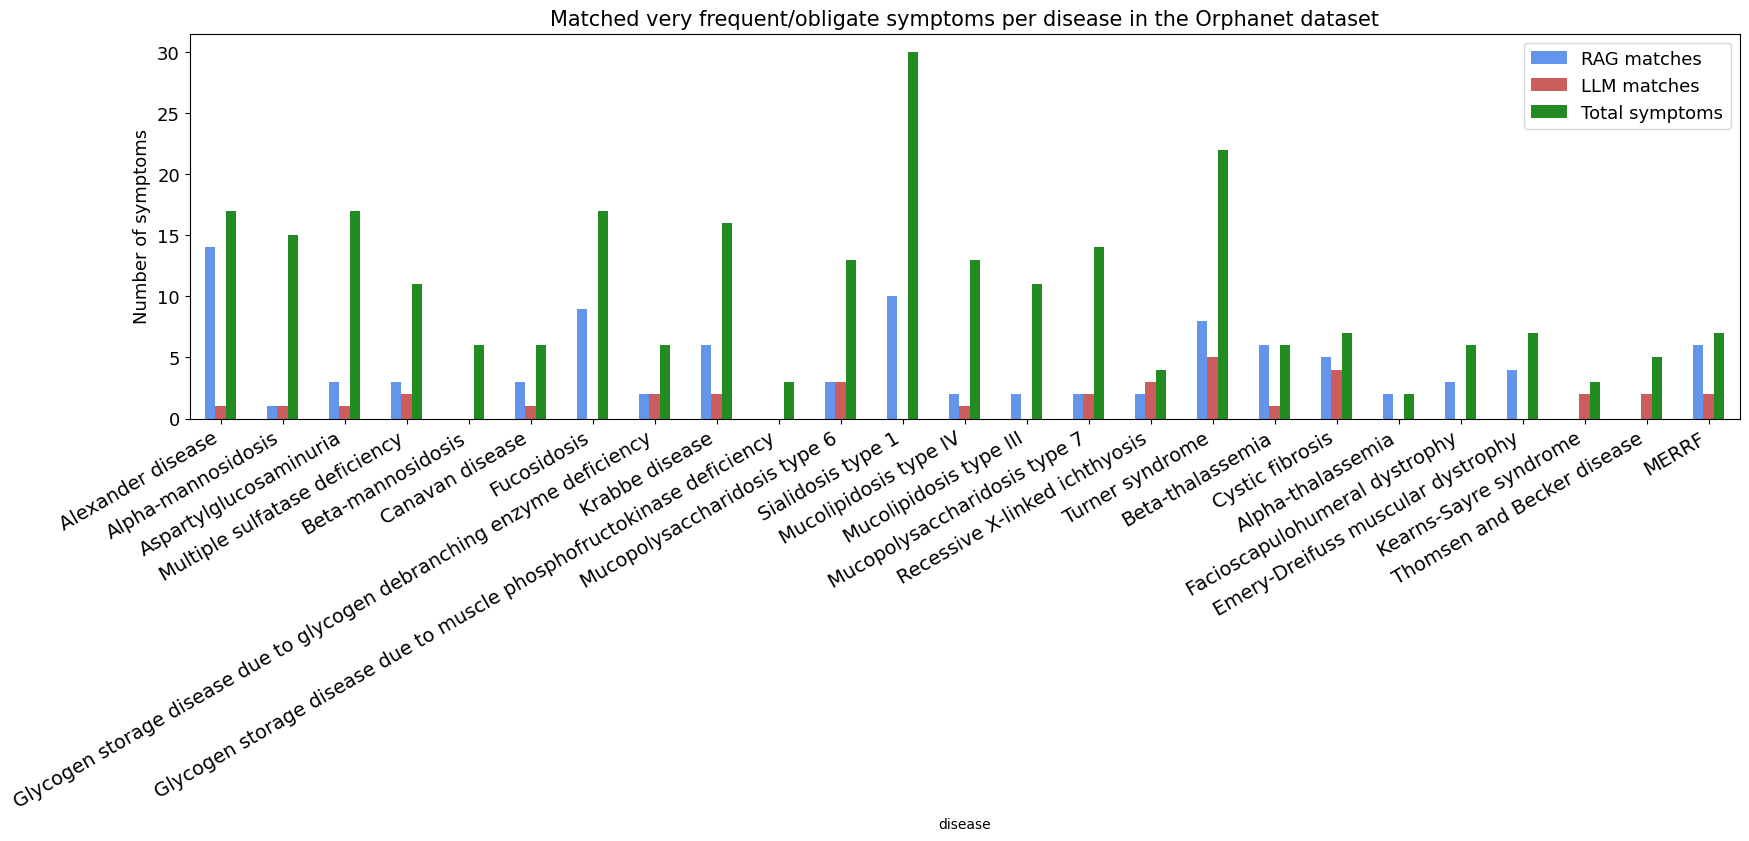

In [37]:
# orpha_freq_results 
orpha_freq_results[:25].plot(
    x="disease",
    y=["rag_matches", "no_rag_matches", "total_symptoms"],
    kind="bar",
    color=["cornflowerblue", "indianred", "forestgreen"],
    fontsize=13,
    figsize=(20, 5),
)
plt.title("Matched very frequent/obligate symptoms per disease in the Orphanet dataset", fontsize=15)
plt.ylabel("Number of symptoms", fontsize=13)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.legend(["RAG matches", "LLM matches", "Total symptoms"], fontsize=13)
plt.show()

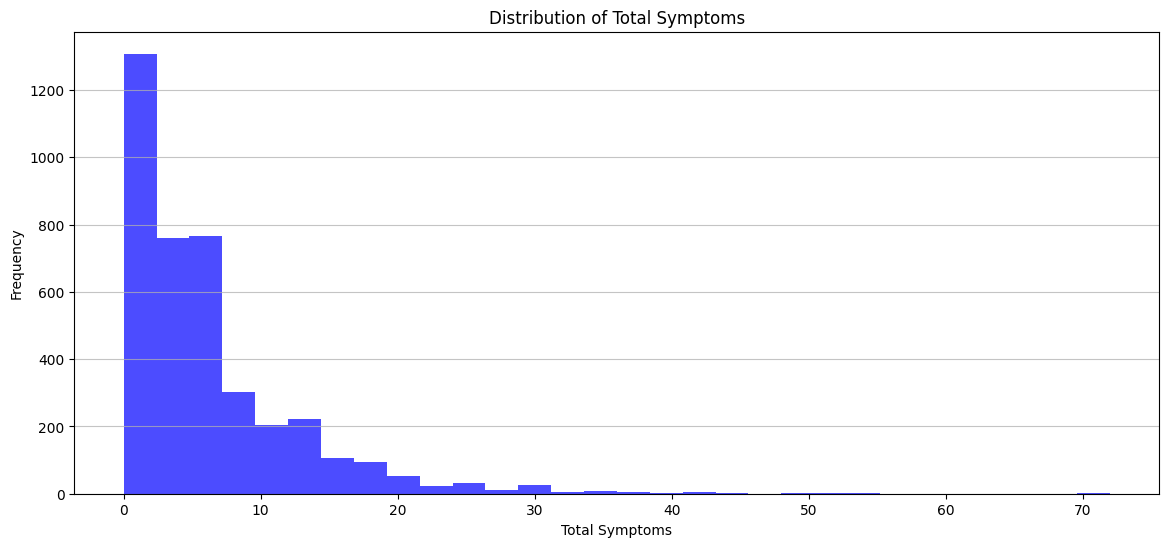

Mean number of symptoms: 27.0 
Most symptoms: 72 
Less symptoms: 0

Number of diseases with 0 symptoms: 493
Average number of symptoms in the RAG response: 24.0
Average number of symptoms in the LLM response: 25.0


In [7]:
plt.figure(figsize=(14, 6))
plt.hist(orpha_freq_results['total_symptoms'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Total Symptoms')
plt.xlabel('Total Symptoms')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

#mean number of symptoms
mean_symptoms = orpha_all_results['total_symptoms'].mean()
print(f"Mean number of symptoms: {round(mean_symptoms,0)} \nMost symptoms: {orpha_freq_results['total_symptoms'].max()} \nLess symptoms: {orpha_freq_results['total_symptoms'].min()}")
print(f"\nNumber of diseases with 0 symptoms: {orpha_freq_results[orpha_freq_results['total_symptoms'] == 0].shape[0]}")

print(f"Average number of symptoms in the RAG response: {round(orpha_freq_results['rag_total_symptoms'].mean(), 0)}")
print(f"Average number of symptoms in the LLM response: {round(orpha_freq_results['no_rag_total_symptoms'].mean(), 0)}")

In [16]:
# % of symptoms matched for the freq 
rag_matches_percentage_freq = orpha_freq_results['rag_matches'].sum() / orpha_freq_results['total_symptoms'].sum() * 100 if orpha_freq_results['total_symptoms'].sum() > 0 else 0
no_rag_matches_percentage_freq = orpha_freq_results['no_rag_matches'].sum() / orpha_freq_results['total_symptoms'].sum() * 100 if orpha_freq_results['total_symptoms'].sum() > 0 else 0
print(f"RAG matches percentage: {round(rag_matches_percentage_freq, 2)}% ({round(orpha_freq_results['rag_matches'].mean(), 0)} symptoms) \nLLM matches percentage: {round(no_rag_matches_percentage_freq, 2)}% ({round(orpha_freq_results['no_rag_matches'].mean(), 0)} symptoms)")

#number of hallucinations
print(f"RAG hallucinations: {round(orpha_freq_results['rag_hallucinations'].mean(), 0)} symptoms \nLLM hallucinations: {round( orpha_freq_results['no_rag_hallucinations'].mean(), 0)} symptoms")

RAG matches percentage: 55.83% (3.0 symptoms) 
LLM matches percentage: 16.78% (1.0 symptoms)
RAG hallucinations: 21.0 symptoms 
LLM hallucinations: 24.0 symptoms


### Split by number of symptoms

In [17]:
symptom_counts = orpha_freq_results['total_symptoms'].values

average_symptoms_per_disease = np.mean(symptom_counts) if len(symptom_counts) > 0 else 0
median_symptoms_per_disease = np.median(symptom_counts) if len(symptom_counts) > 0 else 0
std_dev_symptoms_per_disease = np.std(symptom_counts) if len(symptom_counts) > 0 else 0

print(f"Average number of symptoms per disease: {round(average_symptoms_per_disease, 0)}")
print(f"Median number of symptoms per disease: {round(median_symptoms_per_disease, 0)}")
print(f"Standard deviation of symptoms per disease: {round(std_dev_symptoms_per_disease, 0)}\n")

def assign_symptom_group(symptom_count):
    if symptom_count <= median_symptoms_per_disease:
        return "Low"
    elif symptom_count <= median_symptoms_per_disease + std_dev_symptoms_per_disease:
        return "Medium"
    else:
        return "High"

orpha_freq_results['symptom_group'] = orpha_freq_results['total_symptoms'].apply(assign_symptom_group)

for group in ['Low', 'Medium', 'High']:
    df = orpha_freq_results[orpha_freq_results['symptom_group'] == group]
    print(f"{group} group: {len(df)} diseases", end=" ")
    if len(df) > 0:
        rag_pct = df['rag_matches'].sum() / df['total_symptoms'].sum() * 100
        llm_pct = df['no_rag_matches'].sum() / df['total_symptoms'].sum() * 100
        print(f"| avg symptoms: {df['total_symptoms'].mean():.0f}")
        print(f"RAG matches: {rag_pct:.2f}% ({df['rag_matches'].mean():.0f} symptoms)")
        print(f"LLM matches: {llm_pct:.2f}% ({df['no_rag_matches'].mean():.0f} symptoms)\n")

# summary df
summary_df = pd.DataFrame({
    'Orphanet (frequent)': ['Low (<4 symptoms)', 'Medium (4-11 symptoms)', 'High (>11 symptoms)'],
    'Number of diseases': [len(orpha_freq_results[orpha_freq_results['symptom_group'] == group]) for group in ['Low', 'Medium', 'High']],
    'Average symptoms': [round(orpha_freq_results[orpha_freq_results['symptom_group'] == group]['total_symptoms'].mean(), 0) if len(orpha_freq_results[orpha_freq_results['symptom_group'] == group]) > 0 else 0 for group in ['Low', 'Medium', 'High']],
    'RAG matches (%)': [f"{(orpha_freq_results[orpha_freq_results['symptom_group'] == group]['rag_matches'].sum() / orpha_freq_results[orpha_freq_results['symptom_group'] == group]['total_symptoms'].sum() * 100):.2f}%" if orpha_freq_results[orpha_freq_results['symptom_group'] == group]['total_symptoms'].sum() > 0 else "0%" for group in ['Low', 'Medium', 'High']],
    'RAG hallucinations': [round(orpha_freq_results[orpha_freq_results['symptom_group'] == group]['rag_hallucinations'].mean(), 0) if len(orpha_freq_results[orpha_freq_results['symptom_group'] == group]) > 0 else 0 for group in ['Low', 'Medium', 'High']],
    'LLM matches (%)': [f"{(orpha_freq_results[orpha_freq_results['symptom_group'] == group]['no_rag_matches'].sum() / orpha_freq_results[orpha_freq_results['symptom_group'] == group]['total_symptoms'].sum() * 100):.2f}%" if orpha_freq_results[orpha_freq_results['symptom_group'] == group]['total_symptoms'].sum() > 0 else "0%" for group in ['Low', 'Medium', 'High']],
    'LLM hallucinations': [round(orpha_freq_results[orpha_freq_results['symptom_group'] == group]['no_rag_hallucinations'].mean(), 0) if len(orpha_freq_results[orpha_freq_results['symptom_group'] == group]) > 0 else 0 for group in ['Low', 'Medium', 'High']]
})
summary_df

Average number of symptoms per disease: 6.0
Median number of symptoms per disease: 4.0
Standard deviation of symptoms per disease: 7.0

Low group: 2067 diseases | avg symptoms: 2
RAG matches: 63.30% (1 symptoms)
LLM matches: 26.29% (0 symptoms)

Medium group: 1179 diseases | avg symptoms: 7
RAG matches: 58.58% (4 symptoms)
LLM matches: 20.11% (1 symptoms)

High group: 695 diseases | avg symptoms: 17
RAG matches: 51.56% (9 symptoms)
LLM matches: 11.46% (2 symptoms)



,Orphanet (frequent),Number of diseases,Average symptoms,RAG matches (%),RAG hallucinations,LLM matches (%),LLM hallucinations
0,Low (<4 symptoms),2067,2.0,63.30%,22.0,26.29%,24.0
1,Medium (4-11 symptoms),1179,7.0,58.58%,19.0,20.11%,24.0
2,High (>11 symptoms),695,17.0,51.56%,20.0,11.46%,25.0


## Phenopackets

real patient data, symptoms might also not be related to the condition

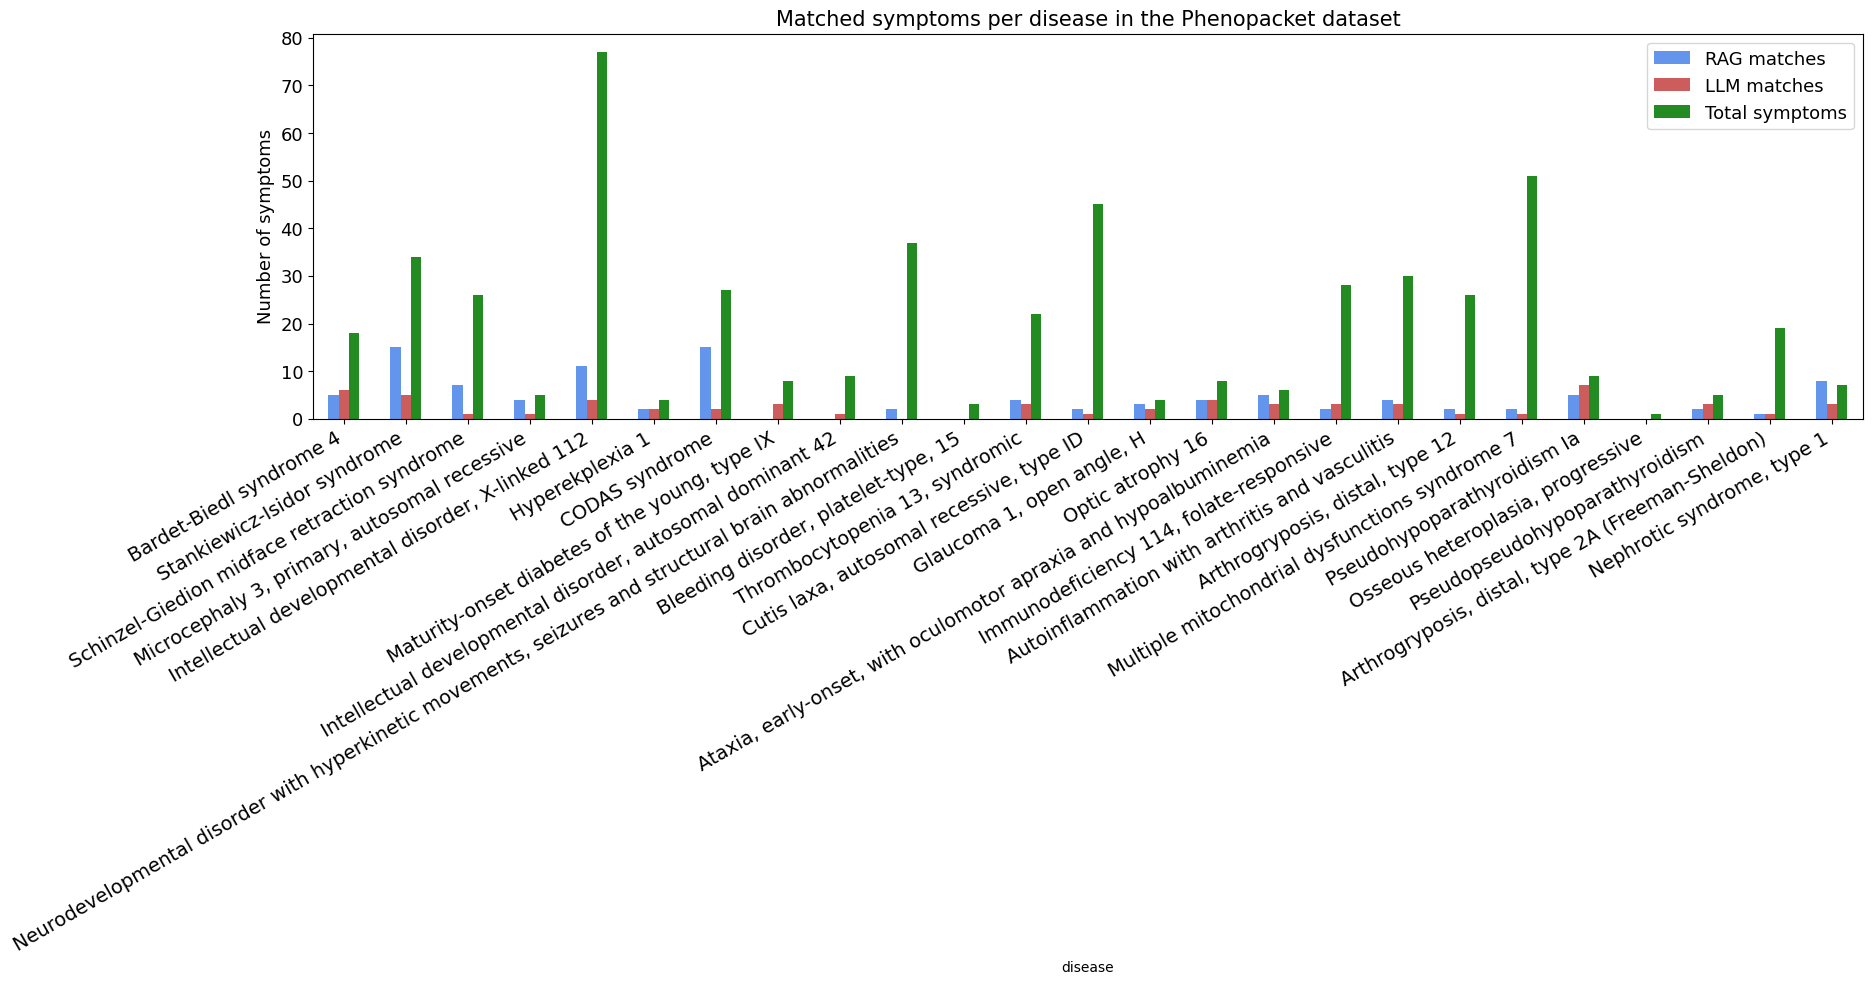

In [42]:
pp_results[25:50].plot(
    x="disease",
    y=["rag_matches", "no_rag_matches", "total_symptoms"],
    kind="bar",
    color=["cornflowerblue", "indianred", "forestgreen"],
    fontsize=13,
    figsize=(20, 5),
)
plt.title("Matched symptoms per disease in the Phenopacket dataset", fontsize=15)
plt.ylabel("Number of symptoms", fontsize=13)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.legend(["RAG matches", "LLM matches", "Total symptoms"], fontsize=13)
plt.show()

In [8]:
rag_matches_percentage_pp = pp_results['rag_matches'].sum() / pp_results['total_symptoms'].sum() * 100 if pp_results['total_symptoms'].sum() > 0 else 0
no_rag_matches_percentage_pp = pp_results['no_rag_matches'].sum() / pp_results['total_symptoms'].sum() * 100 if pp_results['total_symptoms'].sum() > 0 else 0
print(f"RAG matches {round(rag_matches_percentage_pp,2)}% ({round(pp_results['rag_matches'].mean(),0)} symptoms)")
print(f"LLM matches {round(no_rag_matches_percentage_pp,2)}% ({round(pp_results['no_rag_matches'].mean(),0)} symptoms)")
print(f"\nRAG hallucinations: {round(pp_results['rag_hallucinations'].mean(), 0)} symptoms\nNo RAG hallucinations: {round(pp_results['no_rag_hallucinations'].mean(), 0)} symptoms")

print(f"Average number of symptoms in the RAG response: {round(orpha_all_results['rag_total_symptoms'].mean(), 0)}")
print(f"Average number of symptoms in the LLM response: {round(orpha_all_results['no_rag_total_symptoms'].mean(), 0)}")

RAG matches 16.74% (5.0 symptoms)
LLM matches 8.92% (3.0 symptoms)

RAG hallucinations: 26.0 symptoms
No RAG hallucinations: 29.0 symptoms
Average number of symptoms in the RAG response: 24.0
Average number of symptoms in the LLM response: 25.0


### Split by number of cases

load Phenopacket files

In [20]:
# load the disease names from the phenopackets in /home/lasa14/scratch-llm/data/phenopackets/0.1.24/ here there are folders according to gene name, inside each folder there are json files with the phenopackets+
phenopacket_dir = os.path.expanduser('~/scratch-llm/data/phenopackets/0.1.24/')
phenopacket_files = []
for root, dirs, files in os.walk(phenopacket_dir):
    for f in files:
        if f.endswith('.json'):
            phenopacket_files.append(os.path.join(root, f))


count and plot the number of cases per disease

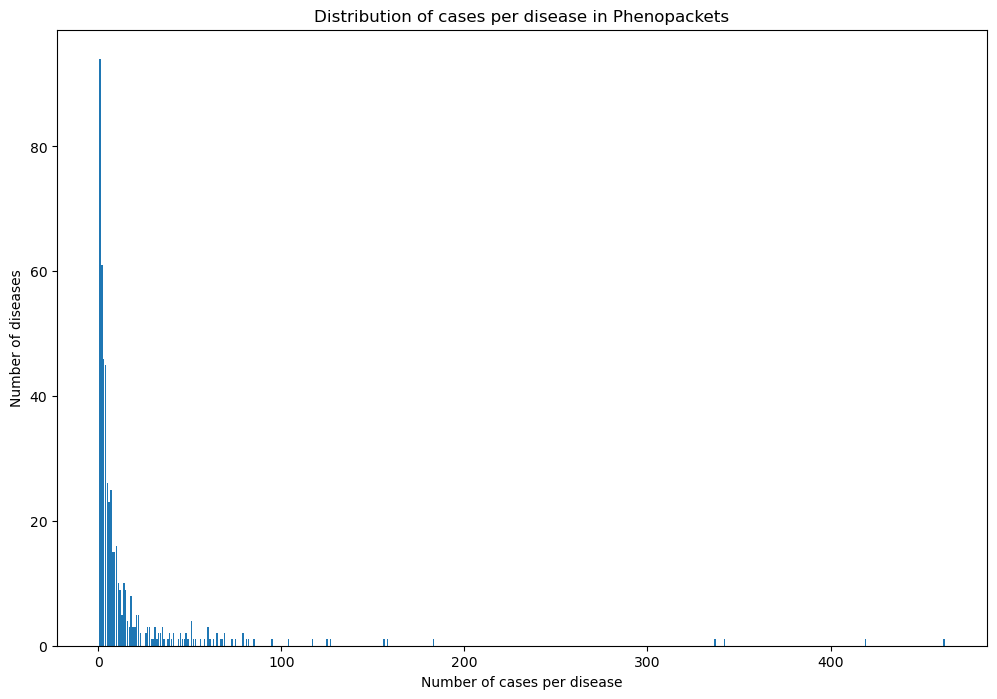

In [21]:
# Count cases per disease
disease_case_counts = Counter()

for file in phenopacket_files:
    with open(file, 'r') as f:
        data = json.load(f)
        disease_label = None
        if 'interpretations' in data:
            for interpretation in data['interpretations']:
                diagnosis = interpretation.get('diagnosis')
                if diagnosis and 'disease' in diagnosis:
                    disease = diagnosis['disease']
                    if 'label' in disease:
                        disease_label = disease['label'].strip()
                        break
        if disease_label:
            disease_case_counts[disease_label] += 1

# Count how many diseases have each number of cases
case_count_distribution = Counter(disease_case_counts.values())

# Plot
plt.figure(figsize=(12, 8))
plt.bar(case_count_distribution.keys(), case_count_distribution.values())
plt.xlabel('Number of cases per disease')
plt.ylabel('Number of diseases')
plt.title('Distribution of cases per disease in Phenopackets')
plt.show()

some statistics and assigning each disease a group according to the number of cases:

In [22]:
# disease_case_counts: {disease: number_of_cases}
case_counts = list(disease_case_counts.values())

average_cases_per_disease = np.mean(case_counts) if case_counts else 0
median_cases_per_disease = np.median(case_counts) if case_counts else 0
std_dev_cases_per_disease = np.std(case_counts) if case_counts else 0

print(f"Average number of cases per disease: {round(average_cases_per_disease, 0)}")
max_case_diseases = [disease for disease, count in disease_case_counts.items() if count == max(case_counts)]
min_case_diseases = [disease for disease, count in disease_case_counts.items() if count == min(case_counts) ]
print(f"Max number of cases: {max(case_counts)} ({len(max_case_diseases)} diseases) | Min number of cases: {min(case_counts)} ({len(min_case_diseases)} diseases)")
print(f"Median number of cases per disease: {round(median_cases_per_disease, 0)}")
print(f"Standard deviation of cases per disease: {round(std_dev_cases_per_disease, 0)}\n")
#max and min number of cases

def assign_group(case_count):
    if case_count <= median_cases_per_disease:
        return "Low"
    elif case_count <= median_cases_per_disease + std_dev_cases_per_disease:
        return "Medium"
    else:
        return "High"

disease_groups = {disease: assign_group(count) for disease, count in disease_case_counts.items()}
pp_results['case_group'] = pp_results['disease'].map(disease_groups)

for group in ['Low', 'Medium', 'High']:
    df = pp_results[pp_results['case_group'] == group]
    print(f"{group} group: {len(df)} diseases", end=" ")
    if len(df) > 0:
        rag_pct = df['rag_matches'].sum() / df['total_symptoms'].sum() * 100
        llm_pct = df['no_rag_matches'].sum() / df['total_symptoms'].sum() * 100
        print(f"| avg symptoms: {df['total_symptoms'].mean():.0f} |", end=" ")
        avg_cases = df['disease'].map(disease_case_counts).mean()
        print(f"avg cases: {avg_cases:.0f}")
        print(f"RAG matches: {rag_pct:.2f}% ({df['rag_matches'].mean():.0f} symptoms)")
        print(f"LLM matches: {llm_pct:.2f}% ({df['no_rag_matches'].mean():.0f} symptoms)\n")

# summary df
summary_df = pd.DataFrame({
    'Group': ['Low (<5 cases)', 'Medium (5-45 cases)', 'High (>45 cases)'],
    'Total number of cases': [pp_results[pp_results['case_group'] == group]['disease'].map(disease_case_counts).sum() for group in ['Low', 'Medium', 'High']],
    'Number of diseases': [len(pp_results[pp_results['case_group'] == group]) for group in ['Low', 'Medium', 'High']],
    'Average symptoms': [round(pp_results[pp_results['case_group'] == group]['total_symptoms'].mean(), 0) if len(pp_results[pp_results['case_group'] == group]) > 0 else 0 for group in ['Low', 'Medium', 'High']],
    'Average cases': [round(pp_results[pp_results['case_group'] == group]['disease'].map(disease_case_counts).mean(), 0) if len(pp_results[pp_results['case_group'] == group]) > 0 else 0 for group in ['Low', 'Medium', 'High']],
    'RAG matches (%)': [f"{(pp_results[pp_results['case_group'] == group]['rag_matches'].sum() / pp_results[pp_results['case_group'] == group]['total_symptoms'].sum() * 100):.2f}%" if pp_results[pp_results['case_group'] == group]['total_symptoms'].sum() > 0 else "0%" for group in ['Low', 'Medium', 'High']],
    'RAG hallucinations': [round(pp_results[pp_results['case_group'] == group]['rag_hallucinations'].mean(), 0) if len(pp_results[pp_results['case_group'] == group]) > 0 else 0 for group in ['Low', 'Medium', 'High']],
    'LLM matches (%)': [f"{(pp_results[pp_results['case_group'] == group]['no_rag_matches'].sum() / pp_results[pp_results['case_group'] == group]['total_symptoms'].sum() * 100):.2f}%" if pp_results[pp_results['case_group'] == group]['total_symptoms'].sum() > 0 else "0%" for group in ['Low', 'Medium', 'High']],
    'LLM hallucinations': [round(pp_results[pp_results['case_group'] == group]['no_rag_hallucinations'].mean(), 0) if len(pp_results[pp_results['case_group'] == group]) > 0 else 0 for group in ['Low', 'Medium', 'High']]
})
summary_df


Average number of cases per disease: 16.0
Max number of cases: 462 (1 diseases) | Min number of cases: 1 (94 diseases)
Median number of cases per disease: 5.0
Standard deviation of cases per disease: 40.0

Low group: 251 diseases | avg symptoms: 15 | avg cases: 2
RAG matches: 21.24% (3 symptoms)
LLM matches: 11.66% (2 symptoms)

Medium group: 180 diseases | avg symptoms: 35 | avg cases: 15
RAG matches: 17.87% (6 symptoms)
LLM matches: 8.69% (3 symptoms)

High group: 40 diseases | avg symptoms: 104 | avg cases: 104
RAG matches: 11.03% (11 symptoms)
LLM matches: 6.81% (7 symptoms)



,Group,Total number of cases,Number of diseases,Average symptoms,Average cases,RAG matches (%),RAG hallucinations,LLM matches (%),LLM hallucinations
0,Low (<5 cases),605,251,15.0,2.0,21.24%,29.0,11.66%,30.0
1,Medium (5-45 cases),2649,180,35.0,15.0,17.87%,24.0,8.69%,29.0
2,High (>45 cases),4164,40,104.0,104.0,11.03%,19.0,6.81%,27.0


In [35]:
print(f"RAG: {[round(pp_results[pp_results['case_group'] == group]['rag_total_symptoms'].mean(), 0) if len(pp_results[pp_results['case_group'] == group]) > 0 else 0 for group in pp_results['case_group'].unique()]}")
print(f"LLM: {[round(pp_results[pp_results['case_group'] == group]['no_rag_total_symptoms'].mean(), 0) if len(pp_results[pp_results['case_group'] == group]) > 0 else 0 for group in pp_results['case_group'].unique()]}")

RAG: [np.float64(30.0), np.float64(32.0), np.float64(30.0)]
LLM: [np.float64(32.0), np.float64(32.0), np.float64(34.0)]


### Split by number of symptoms

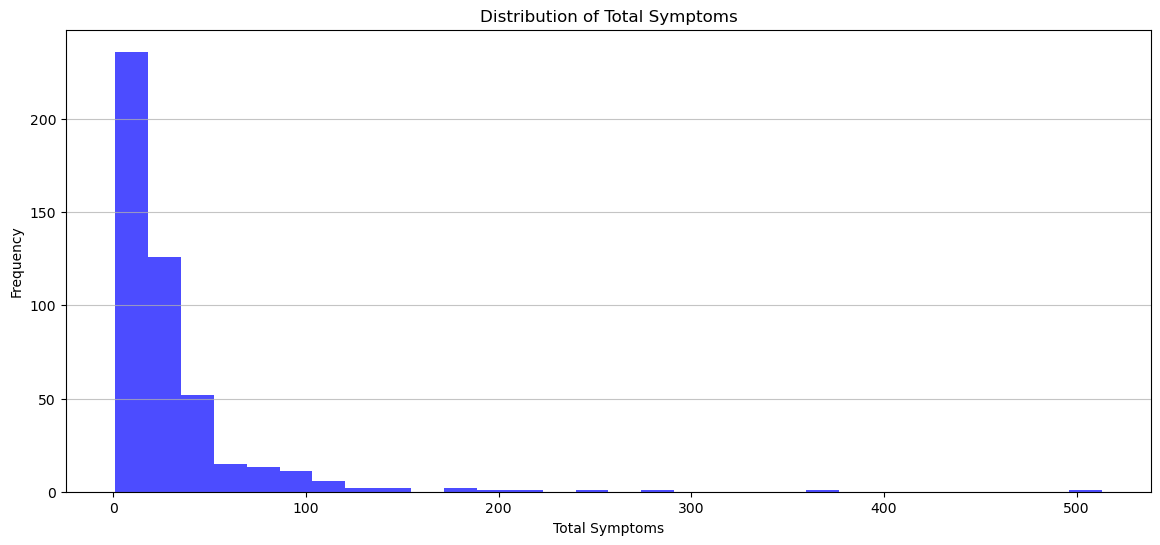

Mean number of symptoms: 30.0 
Max symptoms: 513 
Min symptoms: 1

Number of diseases with 0 symptoms: 0


In [24]:
plt.figure(figsize=(14, 6))
plt.hist(pp_results['total_symptoms'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Total Symptoms')
plt.xlabel('Total Symptoms')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

#mean number of symptoms
mean_symptoms = pp_results['total_symptoms'].mean()
print(f"Mean number of symptoms: {round(mean_symptoms,0)} \nMax symptoms: {pp_results['total_symptoms'].max()} \nMin symptoms: {pp_results['total_symptoms'].min()}")
print(f"\nNumber of diseases with 0 symptoms: {pp_results[pp_results['total_symptoms'] == 0].shape[0]}")

In [25]:
# Group diseases by number of symptoms instead of number of cases

symptom_counts = pp_results['total_symptoms'].values

average_symptoms_per_disease = np.mean(symptom_counts) if len(symptom_counts) > 0 else 0
median_symptoms_per_disease = np.median(symptom_counts) if len(symptom_counts) > 0 else 0
std_dev_symptoms_per_disease = np.std(symptom_counts) if len(symptom_counts) > 0 else 0

print(f"Average number of symptoms per disease: {round(average_symptoms_per_disease, 0)}")
print(f"Median number of symptoms per disease: {round(median_symptoms_per_disease, 0)}")
print(f"Standard deviation of symptoms per disease: {round(std_dev_symptoms_per_disease, 0)}\n")

def assign_symptom_group(symptom_count):
    if symptom_count <= median_symptoms_per_disease:
        return "Low"
    elif symptom_count <= median_symptoms_per_disease + std_dev_symptoms_per_disease:
        return "Medium"
    else:
        return "High"

pp_results['symptom_group'] = pp_results['total_symptoms'].apply(assign_symptom_group)

for group in ['Low', 'Medium', 'High']:
    df = pp_results[pp_results['symptom_group'] == group]
    print(f"{group} group: {len(df)} diseases", end=" ")
    if len(df) > 0:
        rag_pct = df['rag_matches'].sum() / df['total_symptoms'].sum() * 100
        llm_pct = df['no_rag_matches'].sum() / df['total_symptoms'].sum() * 100
        print(f"| avg symptoms: {df['total_symptoms'].mean():.0f}")
        print(f"RAG matches: {rag_pct:.2f}% ({df['rag_matches'].mean():.0f} symptoms)")
        print(f"LLM matches: {llm_pct:.2f}% ({df['no_rag_matches'].mean():.0f} symptoms)\n")

# summary df
summary_df = pd.DataFrame({
    'Phenopackets': ['Low (<18 symptoms)', 'Medium (18-60 symptoms)', 'High (>60 symptoms)'],
    'Number of diseases': [len(pp_results[pp_results['symptom_group'] == group]) for group in ['Low', 'Medium', 'High']],
    'Average symptoms': [round(pp_results[pp_results['symptom_group'] == group]['total_symptoms'].mean(), 0) if len(pp_results[pp_results['symptom_group'] == group]) > 0 else 0 for group in ['Low', 'Medium', 'High']],
    'RAG matches (%)': [f"{(pp_results[pp_results['symptom_group'] == group]['rag_matches'].sum() / pp_results[pp_results['symptom_group'] == group]['total_symptoms'].sum() * 100):.2f}%" if pp_results[pp_results['symptom_group'] == group]['total_symptoms'].sum() > 0 else "0%" for group in ['Low', 'Medium', 'High']],
    'RAG hallucinations': [round(pp_results[pp_results['symptom_group'] == group]['rag_hallucinations'].mean(), 0) if len(pp_results[pp_results['symptom_group'] == group]) > 0 else 0 for group in ['Low', 'Medium', 'High']],
    'LLM matches (%)': [f"{(pp_results[pp_results['symptom_group'] == group]['no_rag_matches'].sum() / pp_results[pp_results['symptom_group'] == group]['total_symptoms'].sum() * 100):.2f}%" if pp_results[pp_results['symptom_group'] == group]['total_symptoms'].sum() > 0 else "0%" for group in ['Low', 'Medium', 'High']],
    'LLM hallucinations': [round(pp_results[pp_results['symptom_group'] == group]['no_rag_hallucinations'].mean(), 0) if len(pp_results[pp_results['symptom_group'] == group]) > 0 else 0 for group in ['Low', 'Medium', 'High']]
})
summary_df

Average number of symptoms per disease: 30.0
Median number of symptoms per disease: 18.0
Standard deviation of symptoms per disease: 42.0

Low group: 236 diseases | avg symptoms: 10
RAG matches: 29.57% (3 symptoms)
LLM matches: 18.46% (2 symptoms)

Medium group: 184 diseases | avg symptoms: 31
RAG matches: 19.08% (6 symptoms)
LLM matches: 8.10% (3 symptoms)

High group: 51 diseases | avg symptoms: 117
RAG matches: 9.45% (11 symptoms)
LLM matches: 5.96% (7 symptoms)



,Phenopackets,Number of diseases,Average symptoms,RAG matches (%),RAG hallucinations,LLM matches (%),LLM hallucinations
0,Low (<18 symptoms),236,10.0,29.57%,29.0,18.46%,29.0
1,Medium (18-60 symptoms),184,31.0,19.08%,25.0,8.10%,30.0
2,High (>60 symptoms),51,117.0,9.45%,15.0,5.96%,28.0


In [26]:
pp_results['total_symptoms'].max()

np.int64(513)

## Summary across the 3 datasets

In [27]:
#make a df with all of the percentages
summary_df = pd.DataFrame({
    "Category": ["RAG", "LLM"],
    "Orphanet (all symptoms)": [f"{round(rag_matches_percentage_all, 2)} %", f"{round(no_rag_matches_percentage_all, 2)} %"],
    "Orphanet (very frequent)": [f"{round(rag_matches_percentage_freq, 2)} %", f"{round(no_rag_matches_percentage_freq, 2)} %"],
    "Phenopackets": [f"{round(rag_matches_percentage_pp, 2)} %", f"{round(no_rag_matches_percentage_pp, 2)} %"],
})
summary_df


,Category,Orphanet (all symptoms),Orphanet (very frequent),Phenopackets
0,RAG,42.08 %,55.83 %,16.74 %
1,LLM,11.15 %,16.78 %,8.92 %


In [28]:
print(f"Out of 4282 diseases in Orphanet (all symptoms), RAG and LLM generated a response for {len(orpha_all_results)} diseases.")
print(f"Out of 4282 diseases in Orphanet (very frequent), RAG and LLM generated a response for {len(orpha_freq_results)} diseases.")
print(f"Out of 516 diseases in the Phenopackets, RAG and LLM generated a response for {len(pp_results)} diseases.")

Out of 4282 diseases in Orphanet (all symptoms), RAG and LLM generated a response for 3941 diseases.
Out of 4282 diseases in Orphanet (very frequent), RAG and LLM generated a response for 3941 diseases.
Out of 516 diseases in the Phenopackets, RAG and LLM generated a response for 471 diseases.


## Other metrics

### Percentage of diseases with more RAG / LLM matches

In [29]:
# count the percentage of diseases with more rag matches, no_rag matches, and equal matches from the results
pp_more_rag = round((pp_results['rag_matches'] > pp_results['no_rag_matches']).sum() / len(pp_results) * 100, 2)
pp_more_no_rag = round((pp_results['no_rag_matches'] > pp_results['rag_matches']).sum() / len(pp_results) * 100, 2)
pp_equal_matches = round((pp_results['rag_matches'] == pp_results['no_rag_matches']).sum() / len(pp_results) * 100, 2)

all_rag_more = round((orpha_all_results['rag_matches'] > orpha_all_results['no_rag_matches']).sum() / len(orpha_all_results) * 100, 2)
all_no_rag_more = round((orpha_all_results['no_rag_matches'] > orpha_all_results['rag_matches']).sum() / len(orpha_all_results) * 100, 2)
all_equal_matches = round((orpha_all_results['rag_matches'] == orpha_all_results['no_rag_matches']).sum() / len(orpha_all_results) * 100, 2)

freq_rag_more = round((orpha_freq_results['rag_matches'] > orpha_freq_results['no_rag_matches']).sum() / len(orpha_freq_results) * 100, 2)
freq_no_rag_more = round((orpha_freq_results['no_rag_matches'] > orpha_freq_results['rag_matches']).sum() / len(orpha_freq_results) * 100, 2)
freq_equal_matches = round((orpha_freq_results['rag_matches'] == orpha_freq_results['no_rag_matches']).sum() / len(orpha_freq_results) * 100, 2)

results_table = pd.DataFrame({
    "Diseases with:": ["RAG > No-RAG", "No-RAG > RAG ", "Equal matches"],
    "Orphanet (all symptoms)": [f"{all_rag_more} %", f"{all_no_rag_more} %", f"{all_equal_matches} %"],
    "Orphanet (very frequent)": [f"{freq_rag_more} %", f"{freq_no_rag_more} %", f"{freq_equal_matches} %"],
    "Phenopackets": [f"{pp_more_rag} %", f"{pp_more_no_rag} %", f"{pp_equal_matches} %"],

})
results_table

,Diseases with:,Orphanet (all symptoms),Orphanet (very frequent),Phenopackets
0,RAG > No-RAG,80.77 %,58.84 %,57.96 %
1,No-RAG > RAG,10.4 %,7.51 %,21.02 %
2,Equal matches,8.83 %,33.65 %,21.02 %


### F1 / Recall / Precision

Text(0.5, 1.0, 'F1 Score distribution for the the Orphanet dataset')

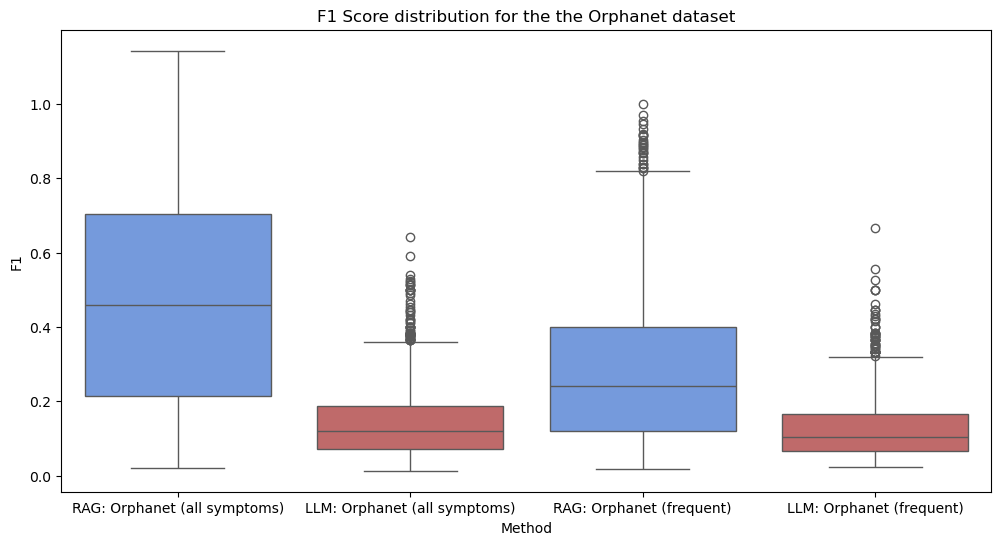

In [30]:
import seaborn as sns

orpha_all_rag_f1 = orpha_all_results['rag_precision'] * orpha_all_results['rag_recall'] / (orpha_all_results['rag_precision'] + orpha_all_results['rag_recall']).replace(0, np.nan) * 2
orpha_all_nonrag_f1 = orpha_all_results['no_rag_precision'] * orpha_all_results['no_rag_recall'] / (orpha_all_results['no_rag_precision'] + orpha_all_results['no_rag_recall']).replace(0, np.nan) * 2

orpha_freq_rag_f1 = orpha_freq_results['rag_precision'] * orpha_freq_results['rag_recall'] / (orpha_freq_results['rag_precision'] + orpha_freq_results['rag_recall']).replace(0, np.nan) * 2
orpha_freq_nonrag_f1 = orpha_freq_results['no_rag_precision'] * orpha_freq_results['no_rag_recall'] / (orpha_freq_results['no_rag_precision'] + orpha_freq_results['no_rag_recall']).replace(0, np.nan) * 2

pp_rag_f1 = pp_results['rag_precision'] * pp_results['rag_recall'] / (pp_results['rag_precision'] + pp_results['rag_recall']).replace(0, np.nan) * 2
pp_nonrag_f1 = pp_results['no_rag_precision'] * pp_results['no_rag_recall'] / (pp_results['no_rag_precision'] + pp_results['no_rag_recall']).replace(0, np.nan) * 2

# create a DataFrame for F1 scores
f1_df = pd.DataFrame({
	'F1': pd.concat([orpha_all_rag_f1, orpha_all_nonrag_f1, orpha_freq_rag_f1, orpha_freq_nonrag_f1], ignore_index=True),
	'Method': ['RAG: Orphanet (all symptoms)'] * len(orpha_all_rag_f1) + ['LLM: Orphanet (all symptoms)'] * len(orpha_all_nonrag_f1) +
			  ['RAG: Orphanet (frequent)'] * len(orpha_freq_rag_f1) + ['LLM: Orphanet (frequent)'] * len(orpha_freq_nonrag_f1)
})

plt.figure(figsize=(12, 6))
sns.boxplot(x='Method', y='F1', hue='Method', data=f1_df, legend=False,
            palette={'RAG: Orphanet (all symptoms)': 'cornflowerblue', 'LLM: Orphanet (all symptoms)': 'indianred',
                     'RAG: Orphanet (frequent)': 'cornflowerblue', 'LLM: Orphanet (frequent)': 'indianred'})
plt.title("F1 Score distribution for the the Orphanet dataset")

In [31]:
# make a table with precision, recall, and F1 scores for both pp_results and orpha_results
precision_recall_f1 = pd.DataFrame({
    "Dataset": ["Orphanet (all)", "Orphanet (all)", "Orphanet (frequent)", "Orphanet (frequent)", "Phenopackets", "Phenopackets"],
    "Method": ["RAG", "LLM", "RAG", "LLM", "RAG", "LLM"],
    "Precision": [round(orpha_all_results['rag_precision'].mean(), 2), round(orpha_all_results['no_rag_precision'].mean(), 2), round(orpha_freq_results['rag_precision'].mean(), 2), round(orpha_freq_results['no_rag_precision'].mean(), 2), round(pp_results['rag_precision'].mean(), 2), round(pp_results['no_rag_precision'].mean(), 2)],
    "Recall": [round(orpha_all_results['rag_recall'].mean(), 2), round(orpha_all_results['no_rag_recall'].mean(), 2), round(orpha_freq_results['rag_recall'].mean(), 2), round(orpha_freq_results['no_rag_recall'].mean(), 2), round(pp_results['rag_recall'].mean(), 2), round(pp_results['no_rag_recall'].mean(), 2)],
    "F1": [round(orpha_all_rag_f1.mean(), 2), round(orpha_all_nonrag_f1.mean(), 2), round(orpha_freq_rag_f1.mean(), 2), round(orpha_freq_nonrag_f1.mean(), 2), round(pp_rag_f1.mean(), 2), round(pp_nonrag_f1.mean(), 2)],
})
precision_recall_f1.set_index(['Dataset', 'Method']).T


Dataset   Orphanet (all)       Orphanet (frequent)       Phenopackets      
Method               RAG   LLM                 RAG   LLM          RAG   LLM
Precision           0.48  0.12                0.15  0.04         0.18  0.09
Recall              0.51  0.14                0.52  0.19         0.26  0.15
F1                  0.47  0.14                0.29  0.13         0.18  0.11

# GPT small dataset

In [32]:
gpt_data = pd.read_csv('/home/lasa14/scratch-llm/results/disease_mode/evaluation/orphanet_all_results_gpt.csv') # GPT is the no_rag


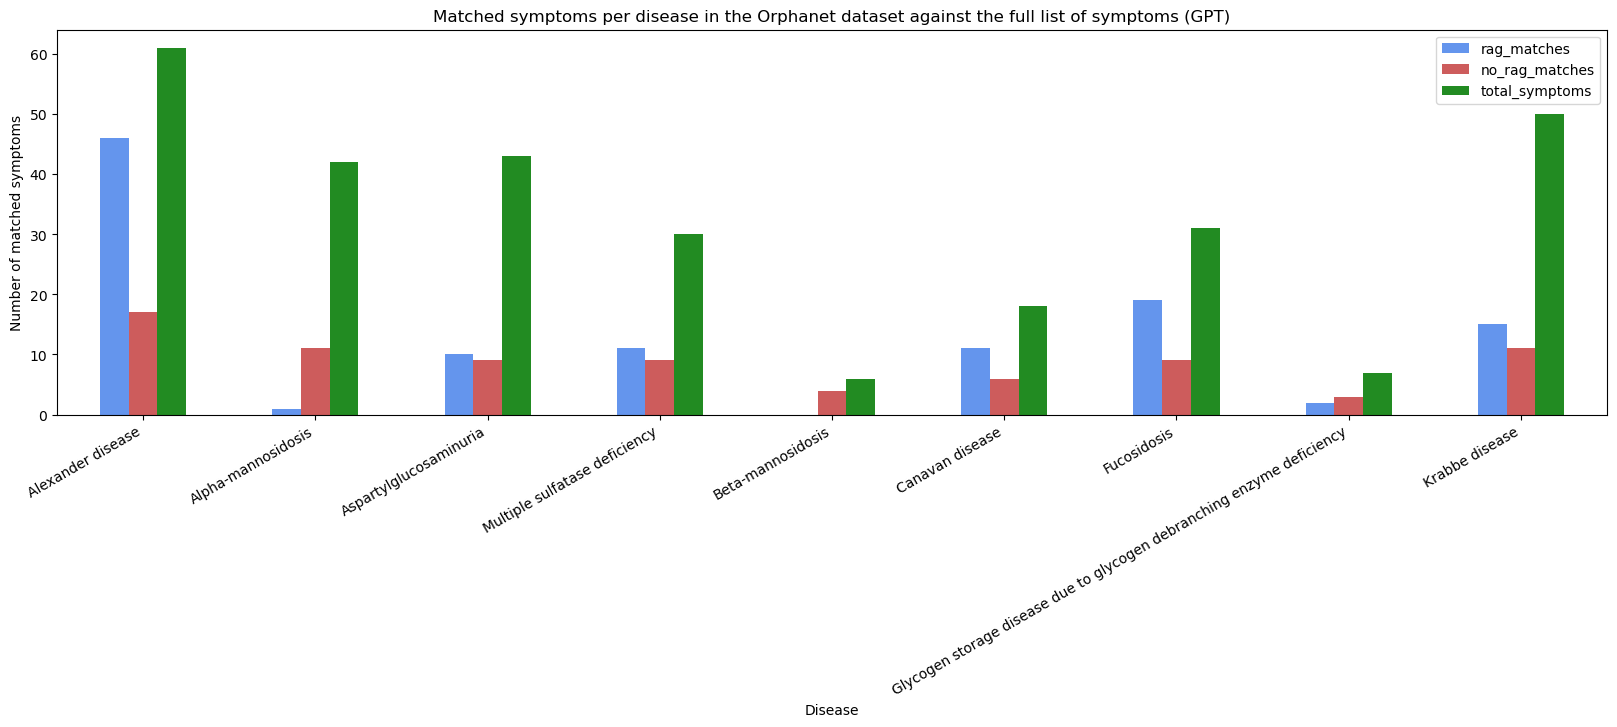

In [33]:
gpt_data.plot(
    x="disease",
    y=["rag_matches", "no_rag_matches", "total_symptoms"],
    kind="bar",
    color=["cornflowerblue", "indianred", "forestgreen"],
    title="Matched symptoms per disease in the Orphanet dataset against the full list of symptoms (GPT)",
    ylabel="Number of matched symptoms",
    xlabel="Disease",
    figsize=(20, 5),
)
plt.xticks(rotation=30, ha='right')
plt.show()

In [34]:
gpt_matches_percentage_orpha = gpt_data['no_rag_matches'].sum() / gpt_data['total_symptoms'].sum() * 100 if gpt_data['total_symptoms'].sum() > 0 else 0
rag_gpt_percentage_orpha = gpt_data['rag_matches'].sum() / gpt_data['total_symptoms'].sum() * 100 if gpt_data['total_symptoms'].sum() > 0 else 0

gpt_summary_df = pd.DataFrame({
    "Model": ["RAG", "ChatGPT"],
    "Orphanet (all symptoms)": [f"{round(rag_gpt_percentage_orpha, 2)} %", f"{round(gpt_matches_percentage_orpha, 2)} %"],
})
gpt_summary_df


,Model,Orphanet (all symptoms)
0,RAG,39.93 %
1,ChatGPT,27.43 %
